### Neurala Nätverk är modeller för Allmän Linjär Regression 

<img src="../Data/mlpnn.jpg">

Ŷ = φ (XW + b)

att jämföra med

$\hat{Y} = \beta_0 + \beta_1X_1 …$

Varje $x_i w_{ij} + b_i$ är alltså en linje! Om aktiveringsfunktionen är linjär, så är hela systemet verkligen "bara" en multipel linjär regression.

### Ickelinjäritet

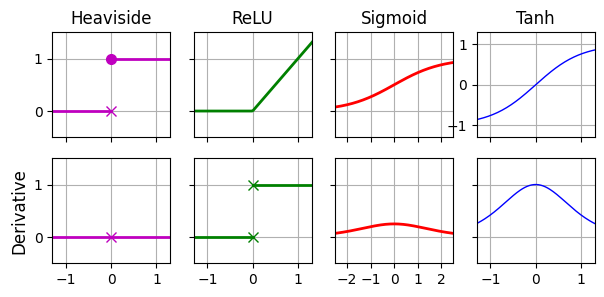

In [70]:
# activation functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

plt.show()



Men vi löser inte detta system med statistisk anpassning. Inte minst kan vi inte hantera diskontinuerliga aktiveringsfunktioner med OLS eller MLE! Med numeriska närmevärden kommer vi undan detta, vilket är matematisk krångligt men praktiskt bekvämt.

Idéen är på ytan enkel, men matematiskt väldigt svårbegriplig! Se Appendix A i boken -- matematiken är mer än vi klarar med algebran vi lärt oss. Framör allt måste vi använda hyperkomplexa tal (_dualer_). För den hugade som inte är rädd för abstrakt algebra har Dr [Michael Penn](https://www.youtube.com/watch?v=ceaNqdHdqtg) en video om dem. Det finns andra enklare videor på youtube, men de begrepp som Dr Penn går igenom är det som faktiskt krävs för att kunna använda dem på egen hand.

I korta; dualer är en sorts tal som har "fler nollor" än vanliga tal. Specifikt finns en särskild symbol $\epsilon$ som har egenskapen $\epsilon^2 = 0$ (jämför med komplexa tal $i^2 = -1$).


<small>Överkurs <br />
En formulering i linjär algebra:
Icke-linjäritet leder till att nollrummets dimension exploderar; det finns alltså fler och fler icke-lösningar. Detta innebär att Jordan dekompositionen inte längre skulle vara nilpotent och vi hamnar i "curse of dimensionality", dvs hittar bara icke-lösningar. Med dualer avbildar vi nollrummet på ett delrum som är nilpotent! Därmed kan vi derivera även icke-kontinuerliga aktiveringsfunktioner, och hitta linjära approximationer till vad som helst i ett litet område kring testdatan! Vi kan till och med formulera det som Taylor-expansion och återsälla Kolmogorovs representationsteorem --> Universal Approximation Theorem för feed-forward NN.
</small>

Istället för att beräkna lutningen på alla linjerna separat, så uppskattar vi lutningarna (vikterna $w_{ij}$) för alla noder på en gång. Detta sker genom två pass genom nätverket: 
* I framåt riktningen beräknas alla noders värden (dvs $x_iw_{ij} + b_i$)
* I bakåt riktningen beräknas de partiella derivatorna för hela det multipla linjära systemet genom en hyperkomplex beräkningsgraf

Detta kallas <em>reverse-mode auto-diff</em>.

Nästa steg för att få en fungerande algoritm för att träna ett NN är att utföra <em>gradient descent</em>, dvs: 
* Justera vikterna $w_{ij}$ ett litet steg i den beräknade gradientens riktning. 

Upprepa!

När vi når något stopp-villkor så är vi klara. Detta kallas 'backpropagation'.

Notera att inget sades om vilken <em>sorts</em> gradient descent som används. I praktiken är <em>mini-batch gradient descent</em> det som är effektivast att köra på GPUer, men särskilt på CPU kan en sann stokastisk gradient descent (där vi alltså sätter någon sannolikhet för varje nod att vara med eller inte) vara lämplig. Detta är mindre sannolikt idag, eftersom även CPUer är väldigt parallella med dussintals, eller till och med hundratals, processorkärnor. 


Modern hårdvara är riktigt snabb, både CPU och GPU. På en AMD 7800X3D/7900GRE (en speldator som är en generation gammal och i näst högsta klassen av den generationens hårdvara) så är prestandan 8x högre för CPU och 4x snabbare för GPU än en gratisinstans på Colab (nVidia T4).

In [71]:
import torch
device = "cuda"

In [72]:
M = torch.rand((1000,1000))
M @ M.T # uppvärming; låter X3D cachen på CPU fyllas
%timeit M @ M.T

M = M.to(device)
M @ M.T # låter GDDR-cache på GPU fyllas
%timeit M @ M.T

2.12 ms ± 82.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
145 μs ± 9.67 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Att jämföra med Colab: <br />
16.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)<br /> 
549 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Notera att AMD/ROCM exekverar annorlunda: 10x fler loopar som var och en tar längre tid men totalt är 7900GRE mycket snabbare än en T4 (och halva priset).

Sklearn har enklare neurala nätverk, men de är väldigt begränsade. Låt oss undersöka dem först, och sedan börja implementera samma sak fast med pytorch. 

In [73]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [74]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [120]:
housing.feature_names, housing.target_names

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

In [ ]:
# in och ut dimensioner räknas ut automatiskt! ReLU mellan dolda lager, linjärt ut och in
# early stopping för att undvika overfit
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50], early_stopping=True, verbose=True)

In [76]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.71649365
Validation score: 0.516983
Iteration 2, loss = 0.27388966
Validation score: 0.646186
Iteration 3, loss = 0.22590612
Validation score: 0.687530
Iteration 4, loss = 0.20695747
Validation score: 0.709635
Iteration 5, loss = 0.19522822
Validation score: 0.717486
Iteration 6, loss = 0.18719984
Validation score: 0.729175
Iteration 7, loss = 0.18154242
Validation score: 0.737790
Iteration 8, loss = 0.17724397
Validation score: 0.742920
Iteration 9, loss = 0.17389133
Validation score: 0.744177
Iteration 10, loss = 0.17346627
Validation score: 0.746943
Iteration 11, loss = 0.16473936
Validation score: 0.754509
Iteration 12, loss = 0.16113489
Validation score: 0.761648
Iteration 13, loss = 0.15853436
Validation score: 0.761040
Iteration 14, loss = 0.15788886
Validation score: 0.763619
Iteration 15, loss = 0.15423616
Validation score: 0.767661
Iteration 16, loss = 0.15297998
Validation score: 0.759259
Iteration 17, loss = 0.15306221
Validation score: 0.767227
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [77]:
mlp_reg.best_validation_score_

0.7813721149489673

In [78]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [79]:
rmse

0.511449586789893

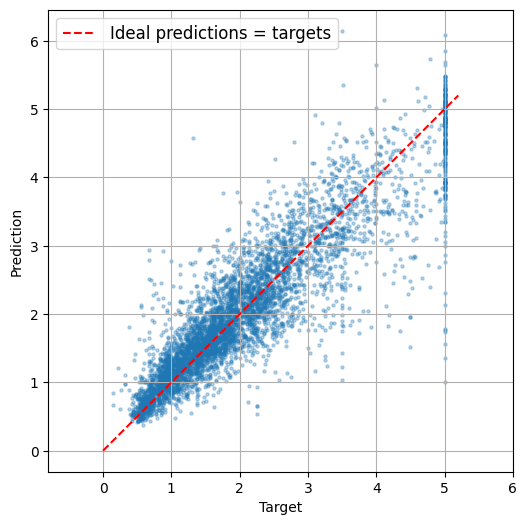

In [80]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0,5.2], color='red', linestyle='--', label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Klassificering

In [105]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-mnist", as_frame=False, parser="liac-arff")
targets = fashion_mnist.target.astype(int)


In [106]:
X_train, y_train = fashion_mnist.data[100:60_000], targets[100:60_000]
X_test , y_test = fashion_mnist.data[60000:], targets[60000:]
X_val, y_val = fashion_mnist.data[:100], targets[:100]

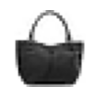

In [107]:
X_sample = X_train[0].reshape(28,28)
plt.figure(figsize=(1,1))
plt.imshow(X_sample, cmap="binary")
plt.axis('off')
plt.show()

In [108]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [109]:
class_names[y_train[0]]

'Bag'

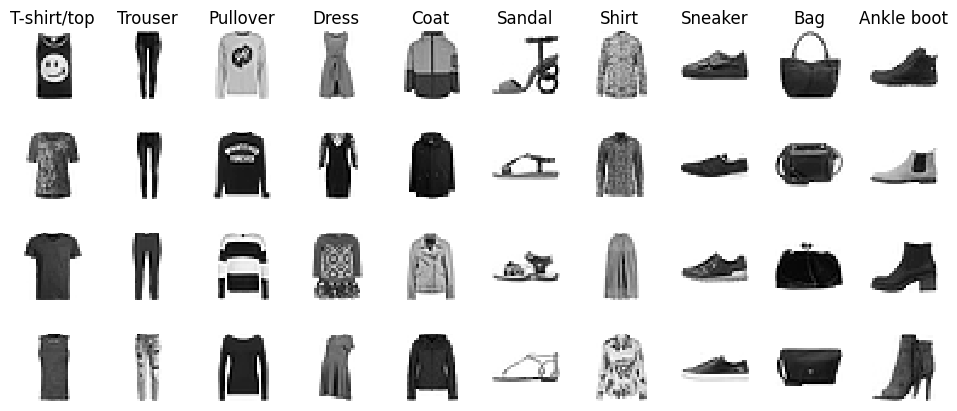

In [110]:
n_rows = 4
plt.figure(figsize=(12, n_rows*1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 *row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [111]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 200], early_stopping=True, verbose=True)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.55236632
Validation score: 0.839900
Iteration 2, loss = 0.38406025
Validation score: 0.857763
Iteration 3, loss = 0.33991396
Validation score: 0.875960
Iteration 4, loss = 0.31416354
Validation score: 0.866945
Iteration 5, loss = 0.29639688
Validation score: 0.879967
Iteration 6, loss = 0.27998392
Validation score: 0.888314
Iteration 7, loss = 0.26413996
Validation score: 0.881970
Iteration 8, loss = 0.24993545
Validation score: 0.889649
Iteration 9, loss = 0.24167027
Validation score: 0.894157
Iteration 10, loss = 0.23560152
Validation score: 0.897329
Iteration 11, loss = 0.22439894
Validation score: 0.894658
Iteration 12, loss = 0.21243441
Validation score: 0.895826
Iteration 13, loss = 0.20857585
Validation score: 0.896327
Iteration 14, loss = 0.20181044
Validation score: 0.891653
Iteration 15, loss = 0.19149557
Validation score: 0.905676
Iteration 16, loss = 0.18339346
Validation score: 0.902838
Iteration 17, loss = 0.18041457
Validation score: 0.899332
Iterat

In [112]:
accuracy

0.8937

In [113]:
mlp_clf.best_validation_score_

0.9056761268781303

In [114]:
mlp_clf.score(X_val, y_val)

0.88

In [115]:
y_hat = mlp_clf.predict(X_val)

In [116]:
y_val

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2,
       0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
       9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])

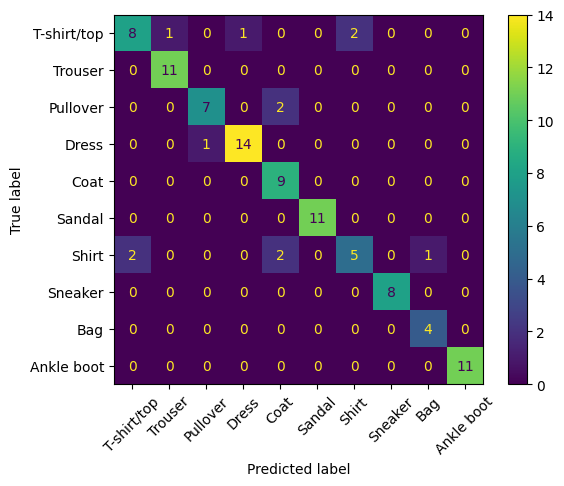

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_val, y_hat)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)


### Backpropagation i Torch

#### Autograd, reverse-mode autodiff i pytorch



$f(x) = x^2$

$f(5) = 25$

$f'(x) = 2x$

$f'(5) = 10$

In [121]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [ ]:
f.backward() # reverse-mode auto-diff
x.grad # f och x är kopplade tack vare requires_grad!

tensor(10.)

#### Gradient descent

In [128]:
learning_rate = 0.1 # hur stort steg vi tar
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x**2 # framåt passet, beräkna alla värden
    f.backward() # bakåtpasset genom beräkningsgrafen
    # gradient descent
    with torch.no_grad(): # koppla inte till gradienterna! vi vill räkna om dem senare
        x -= learning_rate * x.grad
    x.grad.zero_() # sätt gradienterna till 0 så vi räknar om från början



In [ ]:
x # går mot 0, eftersom x^2 har sitt minimum där!

tensor(1.0185e-09, requires_grad=True)

### Linjär regression med pytorch

In [154]:
X_train, X_rest, y_train, y_rest = train_test_split(housing.data, housing.target, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.2)
print(f"Training set: {X_train.shape, y_train.shape}\nValidation set: {X_val.shape, y_val.shape}\nTest set: {X_test.shape, y_test.shape}")

Training set: ((12384, 8), (12384,))
Validation set: ((6604, 8), (6604,))
Test set: ((1652, 8), (1652,))


In [155]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim = 0, keepdim=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_val = (X_val - means) / stds
X_test = (X_test - means) / stds

In [156]:
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


In [165]:
n_features = X_train.shape[1]
w = torch.randn((n_features, 1), requires_grad=True) # initialisera med slumpässiga vikter
b = torch.tensor(0., requires_grad=True)


##### Batch Gradient Descent

In [166]:
learning_rate = 0.4
n_epochs = 20
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train)**2).mean() # MSE
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch +1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/20, Loss: 14.610980033874512
Epoch 2/20, Loss: 3.146758794784546
Epoch 3/20, Loss: 1.568821907043457
Epoch 4/20, Loss: 1.1229534149169922
Epoch 5/20, Loss: 0.9563654065132141
Epoch 6/20, Loss: 0.874260663986206
Epoch 7/20, Loss: 0.8219810128211975
Epoch 8/20, Loss: 0.7825533747673035
Epoch 9/20, Loss: 0.7501232028007507
Epoch 10/20, Loss: 0.7223778963088989
Epoch 11/20, Loss: 0.6982275247573853
Epoch 12/20, Loss: 0.6770465970039368
Epoch 13/20, Loss: 0.6584068536758423
Epoch 14/20, Loss: 0.6419782042503357
Epoch 15/20, Loss: 0.6274877786636353
Epoch 16/20, Loss: 0.6147021055221558
Epoch 17/20, Loss: 0.603418231010437
Epoch 18/20, Loss: 0.5934584140777588
Epoch 19/20, Loss: 0.5846664905548096
Epoch 20/20, Loss: 0.5769046545028687


In [167]:
with torch.no_grad():
    y_pred = X_test @ w + b
    

In [170]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.5896456241607666

#### Direkt med pytorch

In [171]:
import torch.nn as nn
model = nn.Linear(in_features=n_features, out_features=1)


In [172]:
model.bias

Parameter containing:
tensor([0.2925], requires_grad=True)

In [173]:
model.weight

Parameter containing:
tensor([[-0.0226, -0.2269,  0.1089, -0.2399,  0.1244,  0.3532, -0.2282, -0.1768]],
       requires_grad=True)

In [174]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0226, -0.2269,  0.1089, -0.2399,  0.1244,  0.3532, -0.2282, -0.1768]],
       requires_grad=True)
Parameter containing:
tensor([0.2925], requires_grad=True)


In [175]:
model(X_train[:2])

tensor([[0.4199],
        [0.5850]], grad_fn=<AddmmBackward0>)

In [176]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

In [177]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train) # hela träningssettet, alltså Batch Gradient Descent
        loss = criterion(y_pred, y_train) # optimeringsvillkor, kostnadsfunktion, loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


In [178]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/20, Loss: 4.68473482131958
Epoch 2/20, Loss: 0.8146712183952332
Epoch 3/20, Loss: 0.6232412457466125
Epoch 4/20, Loss: 0.5967702269554138
Epoch 5/20, Loss: 0.5844395160675049
Epoch 6/20, Loss: 0.5756247639656067
Epoch 7/20, Loss: 0.5684566497802734
Epoch 8/20, Loss: 0.562341034412384
Epoch 9/20, Loss: 0.5570232272148132
Epoch 10/20, Loss: 0.5523629188537598
Epoch 11/20, Loss: 0.5482653379440308
Epoch 12/20, Loss: 0.5446574091911316
Epoch 13/20, Loss: 0.5414784550666809
Epoch 14/20, Loss: 0.5386766791343689
Epoch 15/20, Loss: 0.5362070202827454
Epoch 16/20, Loss: 0.5340299606323242
Epoch 17/20, Loss: 0.5321106910705566
Epoch 18/20, Loss: 0.5304187536239624
Epoch 19/20, Loss: 0.528927206993103
Epoch 20/20, Loss: 0.5276121497154236


In [179]:
with torch.no_grad():
    y_pred = X_test @ w + b
mean_squared_error(y_test, y_pred)

0.5896456241607666